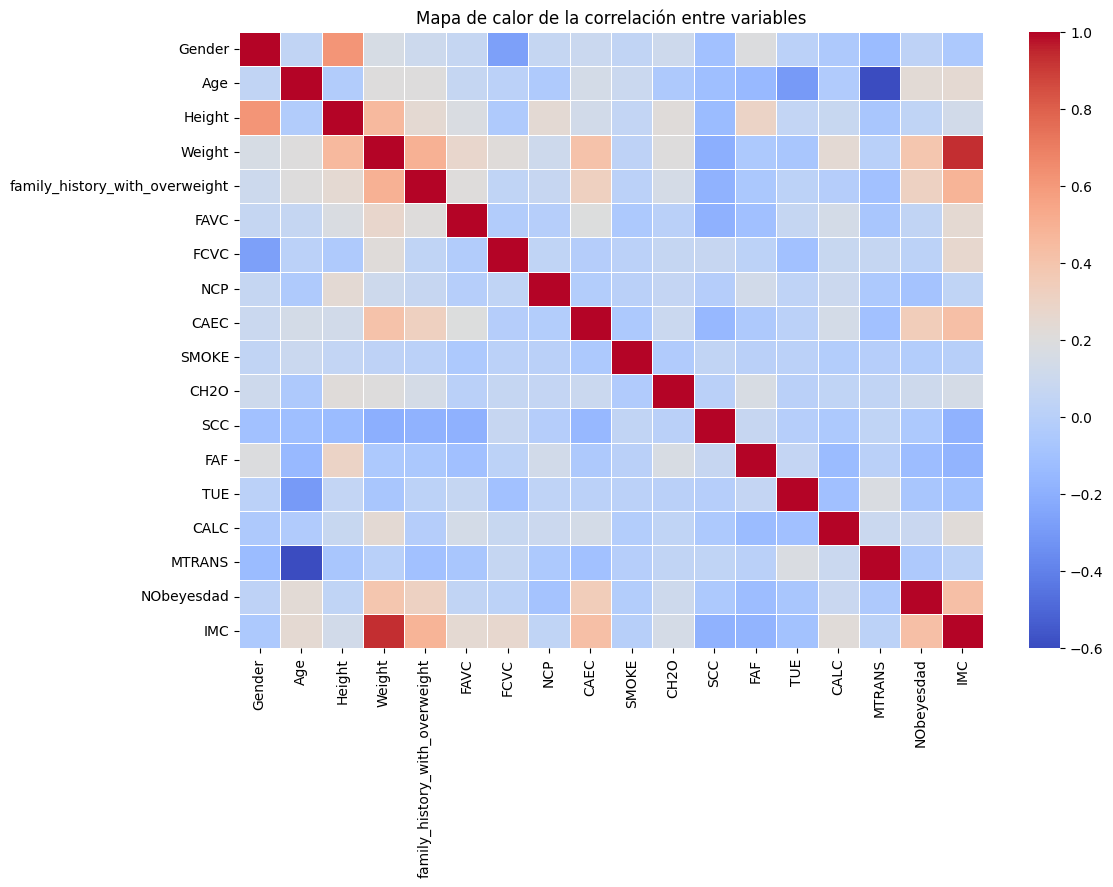

/Users/gmr/Desktop/master/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmr/Desktop/master/.venv/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/gmr/Desktop/master/.venv/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, mean_absolute_error, precision_score, r2_score, mean_squared_error, recall_score, roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler,  SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss


df = pd.read_csv("ObesityDataSet_raw_and_data_sinthetic.csv")

labelEncoder = LabelEncoder()
scaler = StandardScaler()

weight = df['Weight']
height = df['Height']**2

imc = weight / height

df['IMC'] = imc.astype(float)

df['Gender'] = labelEncoder.fit_transform(df['Gender'])
df['SMOKE'] = labelEncoder.fit_transform(df['SMOKE'])
df['family_history_with_overweight'] = labelEncoder.fit_transform(df['family_history_with_overweight'])
df['FAVC'] = labelEncoder.fit_transform(df['FAVC'])
df['SCC'] = labelEncoder.fit_transform(df['SCC'])
df['CAEC'] = df['CAEC'].apply(lambda x: 1 if x == "no" else (2 if x == "Sometimes" else 0))
df['CALC'] = df['CALC'].apply(lambda x: 1 if x == "no" else (2 if x == "Sometimes" else 0))
df['MTRANS'] = labelEncoder.fit_transform(df['MTRANS'])
df['NObeyesdad'] = labelEncoder.fit_transform(df['NObeyesdad'])


corr_matrix = df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, fmt=".2f", cmap="coolwarm", linewidths=0.5)
#sns.pairplot(df, hue="target", diag_kind="kde", markers=["o", "s"])
plt.title("Mapa de calor de la correlación entre variables")
plt.show()

X = df.drop(columns=['NObeyesdad'])
y = df['NObeyesdad']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, x_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# --------------------
# EVALUACIÓN DE MÉTODOS DE BALANCEO
# --------------------
resultados_balanceo = {}

# MODELO
model = LogisticRegression(C=0.1, solver='saga', max_iter=100)

def evaluar_balanceo(X_train_resampled, y_train_resampled, metodo):
    # Selecionamos el modelo
    model.fit(X_train_resampled, y_train_resampled)

    # Sacamos variable con predicciones
    y_pred = model.predict(x_test)

    # funciones de testeo de de balanceo de clases
    f1 = f1_score(y_test, y_pred) * 100
    auc = roc_auc_score(y_test, model.predict_proba(x_test)[:,1]) * 100
    accuracy = accuracy_score(y_test, y_pred) * 100
    precision = precision_score(y_test, y_pred) * 100
    recall = recall_score(y_test, y_pred) * 100
    resultados_balanceo[metodo] = (f1, auc)
    print(f"\nResultados con {metodo}:")
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"Precision: {precision:.2f}%")
    print(f"Recall: {recall:.2f}%")
    print(f"F1-Score: {f1:.2f}%")
    print(f"AUC-ROC: {auc:.2f}%")
    #print(f"Resultados: {resultados_balanceo}")

# --------------------
# MÉTODOS DE BALANCEO DE CLASES
# --------------------

# 1. Sobremuestreo aleatorio
ros = RandomOverSampler(random_state=42)
X_train_balanced, y_train_balanced = ros.fit_resample(X_train, y_train)
evaluar_balanceo(X_train_balanced, y_train_balanced, "Sobremuestreo Aleatorio")

# # 2. SMOTE (Synthetic Minority Over-sampling Technique)
# smote = SMOTE(random_state=42)
# X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
# evaluar_balanceo(X_train_balanced, y_train_balanced, "SMOTE")
# X_train_balanced = None
# y_train_balanced = None

# # 3. Submuestreo aleatorio
# rus = RandomUnderSampler(random_state=42)
# X_train_balanced, y_train_balanced = rus.fit_resample(X_train, y_train)
# evaluar_balanceo(X_train_balanced, y_train_balanced, "Submuestreo Aleatorio")
# X_train_balanced = None
# y_train_balanced = None

# # 4. NearMiss (submuestreo basado en distancia)
# nearmiss = NearMiss()
# X_train_balanced, y_train_balanced = nearmiss.fit_resample(X_train, y_train)
# evaluar_balanceo(X_train_balanced, y_train_balanced, "NearMiss")
# X_train_balanced = None
# y_train_balanced = None

# Seleccionar el mejor método de balanceo
mejor_metodo = max(resultados_balanceo, key=lambda k: resultados_balanceo[k])
print(f"\nEl mejor método de balanceo es: {mejor_metodo} con F1-Score: {resultados_balanceo[mejor_metodo][0]:.2f}% y AUC-ROC: {resultados_balanceo[mejor_metodo][1]:.2f}%")

X_train_resampled, y_train_resampled = X_train_balanced, y_train_balanced
